In [6]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from math import ceil, sqrt
import time

In [7]:
train = pd.read_csv("data.csv")


# Deleting columns with many None values
train = train.drop(["MiscFeature"], axis=1)
train = train.drop(["Fence"], axis=1)
train = train.drop(["PoolQC"], axis=1)
train = train.drop(["FireplaceQu"], axis=1)
train = train.drop(["MasVnrType"], axis=1)
train = train.drop(["Alley"], axis=1)

train = train.dropna()
train.reset_index(inplace=True, drop=True)

train = train.drop(["Id"], axis = 1)
train = pd.get_dummies(train)

breakpoint = int(len(train)*0.9)
x_train = train.iloc[0:breakpoint].drop(["SalePrice"], axis=1)
y_train = train.iloc[0:breakpoint]["SalePrice"]

x_test = train.iloc[breakpoint:].drop(["SalePrice"], axis=1)
y_test = train.iloc[breakpoint:]["SalePrice"]


# x_train.info()
# x_test.info()



In [8]:
def get_score(trees, x, y_true):
    y_pred = predict(trees, x)
    u = ((y_true - y_pred)** 2).sum()
    v = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - (u/v)


def predict(trees, x):
    sums = trees[0].predict(x)
    for tree in trees[1:]:
        sums += tree.predict(x)
    return sums/len(trees)


def forest_implementation(max_depth, number_of_trees, max_features, max_weight):
    tab_scores = np.zeros(10)
    tab_mse = np.zeros(10)
    tab_abs_error = np.zeros(10)
    for i in range(10):
        trees = []
        number_of_samples = len(x_train)
        errors = [1 for i in range(len(x_train))]
        train_samples = int(0.632*len(x_train))
        for n_tree in range(number_of_trees):
            samples = np.random.choice(number_of_samples, size=train_samples, replace=True, p=errors/np.sum(errors))
            x_temp = x_train.iloc[samples]
            y_temp = y_train.iloc[samples]
            tree = DecisionTreeRegressor(max_depth=max_depth, max_features=max_features)
            tree.fit(x_temp, y_temp)
            trees.append(tree)
            values = predict(trees, x_train)
            absolute_error = np.abs(values - y_train)
            errors = np.array([1 for i in range(len(x_train))]) + absolute_error/np.max(absolute_error) * (max_weight - 1)

        y_pred = predict(trees, x_test)
        mse = np.mean((y_test - y_pred)**2)
        abs_error = np.mean(np.abs(y_test - y_pred))
        tab_scores[i] = get_score(trees, x_test, y_test)
        tab_mse[i] = mse
        tab_abs_error[i] = abs_error
    return np.mean(tab_scores), np.mean(tab_mse), np.mean(tab_abs_error)


def random_forest_sklearn(max_depth, number_of_trees, max_features):
    tab_scores = np.zeros(10)
    tab_mse = np.zeros(10)
    tab_absolute_error = np.zeros(10)
    for i in range(10):
        forest = RandomForestRegressor(max_depth=max_depth, n_estimators=number_of_trees, max_features=max_features)
        forest.fit(x_train, y_train)
        score = forest.score(x_test, y_test)
        y_pred = forest.predict(x_test)
        mse = np.mean((y_test - y_pred)**2)
        absolute_error = np.mean(np.abs(y_test - y_pred))
        tab_scores[i] = score
        tab_mse[i] = mse
        tab_absolute_error[i] = absolute_error
    return np.mean(tab_scores), np.mean(tab_mse), np.mean(tab_absolute_error)




In [10]:
max_depth = [4, 7, 10, 15, 20, 30]
number_of_trees = [10, 30, 50, 100, 150, 200]
max_weight = [2, 5, 10, 20, 50, 100]
features_num = x_train.shape[1] # 255 -> sqrt ~ 16
max_features = [5, 10, int(sqrt(features_num)), 50, 100, 200]

max_depth_default = 10
number_of_trees_default = 100
max_features_default = int(sqrt(features_num))
max_weight_default = 10

scores_sklearn = []
mse_sklearn = []
abs_errors_sklearn = []
times_sklearn = []

scores_implementation = []
mse_implementation = []
abs_errors_implementation = []
times_implementation = []


def evaluate_sklearn(max_depth, number_of_trees, max_features):
    start_time = time.time()
    score, mse, abs_error = random_forest_sklearn(max_depth, number_of_trees, max_features)
    exec_time = (time.time() - start_time)
    scores_sklearn.append(score)
    mse_sklearn.append(mse)
    abs_errors_sklearn.append(abs_error)
    times_sklearn.append(exec_time)

def evaluate_implementation(max_depth, number_of_trees, max_features, max_weight):
    start_time = time.time()
    score, mse, abs_error = forest_implementation(max_depth, number_of_trees, max_features, max_weight)
    exec_time = (time.time() - start_time)
    scores_implementation.append(score)
    mse_implementation.append(mse)
    abs_errors_implementation.append(abs_error)
    times_implementation.append(exec_time)


for depth in max_depth:
    evaluate_sklearn(depth, number_of_trees_default, max_features_default)
    evaluate_implementation(depth, number_of_trees_default, max_features_default, max_weight_default)


print('SKLEARN')
print('Depths: ', max_depth)
print('Mse: ', mse_sklearn)
print('Abs error: ', abs_errors_sklearn)
print('Scores: ', scores_sklearn)
print('Times: ', times_sklearn, '\n')

print('IMPLEMENTATION')
print('Depths: ', max_depth)
print('Mse: ', mse_implementation)
print('Abs error: ', abs_errors_implementation)
print('Scores: ', scores_implementation)
print('Times: ', times_implementation)



SKLEARN
Depths:  [4, 7, 10, 15, 20, 30]
Mse:  [970842280.5280018, 729327617.7603534, 630356160.6245319, 605428106.4940126, 606635878.6575496, 627398685.0931331]
Abs error:  [22697.359533897918, 18910.658333127256, 17271.64259999788, 16517.203730052534, 16538.48933890488, 16835.50378030303]
Scores:  [0.7857054281578685, 0.8390150978018834, 0.8608611241409694, 0.8663635077864896, 0.8660969155460618, 0.8615139294065063]
Times:  [1.5337417125701904, 2.0008158683776855, 2.1417829990386963, 2.627315044403076, 2.756673812866211, 3.0470407009124756] 

IMPLEMENTATION
Depths:  [4, 7, 10, 15, 20, 30]
Mse:  [878834448.3364866, 669220991.9140911, 620830651.9721935, 606333151.7758749, 593843517.079225, 606464187.297309]
Abs error:  [21577.65249268082, 18117.018260513993, 17179.05773645775, 16800.0501581136, 16623.53323839741, 16667.618733333333]
Scores:  [0.8060143695802386, 0.8522824677021672, 0.8629636951137962, 0.8661637366237949, 0.8689205808336778, 0.8661348130782047]
Times:  [224.2620205879211

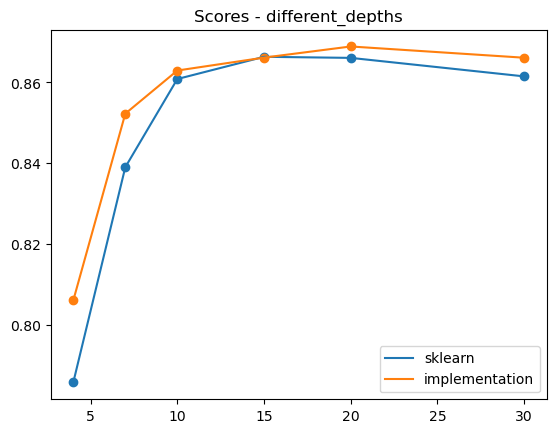

In [16]:
from matplotlib import pyplot as plt


plt.scatter(max_depth, scores_sklearn)
plt.plot(max_depth, scores_sklearn, label="sklearn")
plt.scatter(max_depth, scores_implementation)
plt.plot(max_depth, scores_implementation, label = "implementation")
plt.title("Scores - different_depths")
plt.legend()
plt.show()





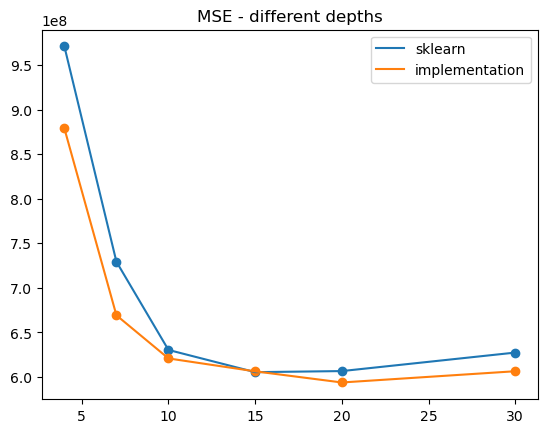

In [17]:
plt.scatter(max_depth, mse_sklearn)
plt.plot(max_depth, mse_sklearn, label="sklearn")
plt.scatter(max_depth, mse_implementation)
plt.plot(max_depth, mse_implementation, label = "implementation")
plt.title("MSE - different depths")
plt.legend()
plt.show()

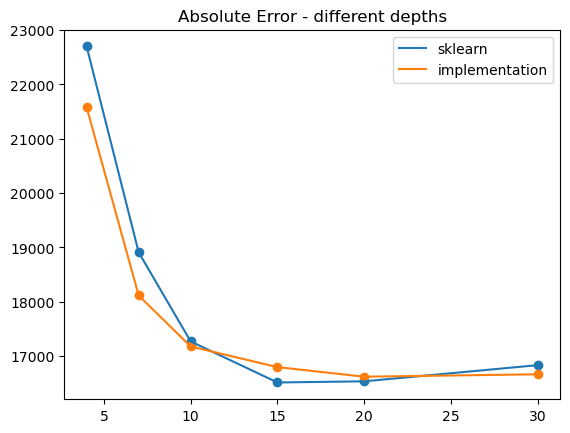

In [18]:
plt.scatter(max_depth, abs_errors_sklearn)
plt.plot(max_depth, abs_errors_sklearn, label="sklearn")
plt.scatter(max_depth, abs_errors_implementation)
plt.plot(max_depth, abs_errors_implementation, label = "implementation")
plt.title("Absolute Error - different depths")
plt.legend()
plt.show()

In [19]:
scores_sklearn = []
mse_sklearn = []
abs_errors_sklearn = []
times_sklearn = []

scores_implementation = []
mse_implementation = []
abs_errors_implementation = []
times_implementation = []


for num_of_trees in number_of_trees:
    print(f'START: {num_of_trees}')
    evaluate_sklearn(max_depth_default, num_of_trees, max_features_default)
    evaluate_implementation(max_depth_default, num_of_trees, max_features_default, max_weight_default)



print('SKLEARN')
print('Number of trees: ', number_of_trees)
print('Mse: ', mse_sklearn)
print('Abs error: ', abs_errors_sklearn)
print('Scores: ', scores_sklearn)
print('Times: ', times_sklearn, '\n')

print('IMPLEMENTATION')
print('Number of trees: ', number_of_trees)
print('Mse: ', mse_implementation)
print('Abs error: ', abs_errors_implementation)
print('Scores: ', scores_implementation)
print('Times: ', times_implementation)

START: 10
START: 30
START: 50
START: 100
START: 150
START: 200
SKLEARN
Number of trees:  [10, 30, 50, 100, 150, 200]
Mse:  [814569825.2876416, 665736416.156012, 651534791.9443125, 623084537.1389548, 637151282.4176457, 644239807.1877993]
Abs error:  [19732.401902874924, 17730.648270464862, 17386.297141196916, 17097.467490519397, 17236.101547978564, 17294.701947518457]
Scores:  [0.8201995365811632, 0.8530516201022079, 0.856186352736899, 0.8624661937518555, 0.8593612330211897, 0.8577965788944798]
Times:  [0.4405183792114258, 0.7535192966461182, 1.2967455387115479, 2.3988590240478516, 3.4482600688934326, 4.56868839263916] 

IMPLEMENTATION
Number of trees:  [10, 30, 50, 100, 150, 200]
Mse:  [827120430.6595184, 678750593.170843, 653130132.4676481, 624459543.538316, 615003723.7578034, 602434326.4779023]
Abs error:  [20190.38314166956, 18056.922958284307, 17681.10466622367, 17212.072139210857, 17075.076828323254, 16881.209167561137]
Scores:  [0.8174292342792662, 0.8501789933664272, 0.855834212

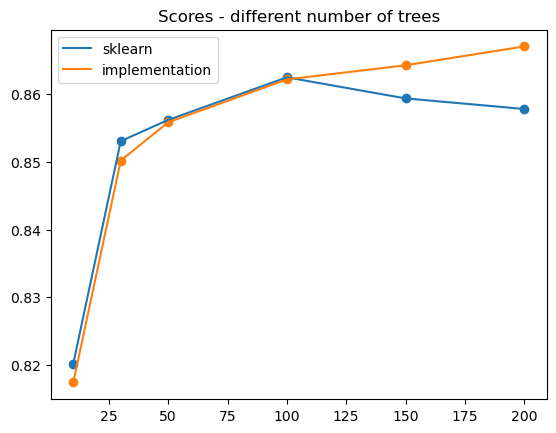

In [26]:
plt.scatter(number_of_trees, scores_sklearn)
plt.plot(number_of_trees, scores_sklearn, label="sklearn")
plt.scatter(number_of_trees, scores_implementation)
plt.plot(number_of_trees, scores_implementation, label = "implementation")
plt.title("Scores - different number of trees")
plt.legend()
plt.show()

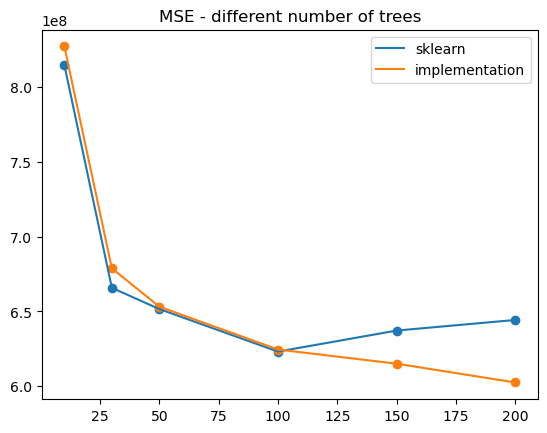

In [25]:
plt.scatter(number_of_trees, mse_sklearn)
plt.plot(number_of_trees, mse_sklearn, label="sklearn")
plt.scatter(number_of_trees, mse_implementation)
plt.plot(number_of_trees, mse_implementation, label = "implementation")
plt.title("MSE - different number of trees")
plt.legend()
plt.show()

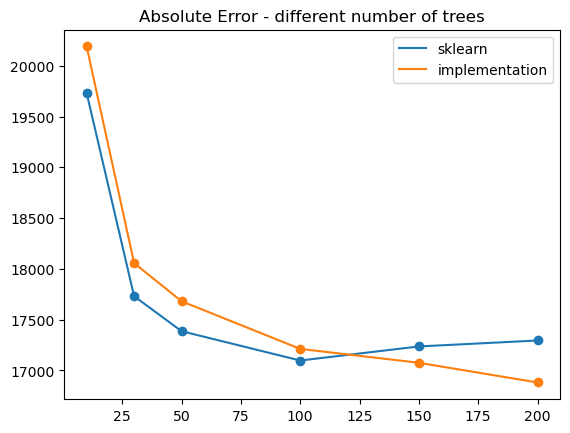

In [24]:
plt.scatter(number_of_trees, abs_errors_sklearn)
plt.plot(number_of_trees, abs_errors_sklearn, label="sklearn")
plt.scatter(number_of_trees, abs_errors_implementation)
plt.plot(number_of_trees, abs_errors_implementation, label = "implementation")
plt.title("Absolute Error - different number of trees")
plt.legend()
plt.show()

In [27]:
scores_sklearn = []
mse_sklearn = []
abs_errors_sklearn = []
times_sklearn = []

scores_implementation = []
mse_implementation = []
abs_errors_implementation = []
times_implementation = []


for weight in max_weight:
    print(f'START: {weight}')
    evaluate_sklearn(max_depth_default, number_of_trees_default, max_features_default)
    evaluate_implementation(max_depth_default, number_of_trees_default, max_features_default, weight)



print('SKLEARN')
print('Weights: ', max_weight)
print('Mse: ', mse_sklearn)
print('Abs error: ', abs_errors_sklearn)
print('Scores: ', scores_sklearn)
print('Times: ', times_sklearn, '\n')

print('IMPLEMENTATION')
print('Weights: ', max_weight)
print('Mse: ', mse_implementation)
print('Abs error: ', abs_errors_implementation)
print('Scores: ', scores_implementation)
print('Times: ', times_implementation)

START: 2
START: 5
START: 10
START: 20
START: 50
START: 100
SKLEARN
Weights:  [2, 5, 10, 20, 50, 100]
Mse:  [648637479.6343544, 642926307.2411675, 638850698.2917899, 640455384.4563816, 659312520.5469291, 644017223.4135623]
Abs error:  [17335.836296454825, 17304.92142060956, 17381.500513211366, 17308.165595313618, 17650.31808066055, 17188.547080745975]
Scores:  [0.8568258781401579, 0.85808650848894, 0.85898611998333, 0.8586319166884394, 0.8544695702540681, 0.8578457099382714]
Times:  [2.5664966106414795, 2.8280787467956543, 2.324427366256714, 2.178391456604004, 2.20570707321167, 2.209393262863159] 

IMPLEMENTATION
Weights:  [2, 5, 10, 20, 50, 100]
Mse:  [647955692.8017367, 621268281.2907524, 611313936.0732952, 627178185.9832811, 611629507.7604058, 603386171.3385417]
Abs error:  [17497.29714241507, 17252.554658904934, 17097.55083500276, 17328.331333951857, 17014.363619263153, 16857.3197998142]
Scores:  [0.856976369337661, 0.8628670969440142, 0.8650643252571276, 0.8615626003011357, 0.86499

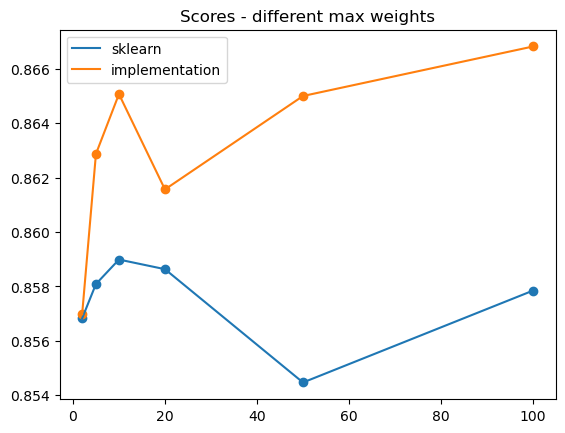

In [28]:
plt.scatter(max_weight, scores_sklearn)
plt.plot(max_weight, scores_sklearn, label="sklearn")
plt.scatter(max_weight, scores_implementation)
plt.plot(max_weight, scores_implementation, label = "implementation")
plt.title("Scores - different max weights")
plt.legend()
plt.show()

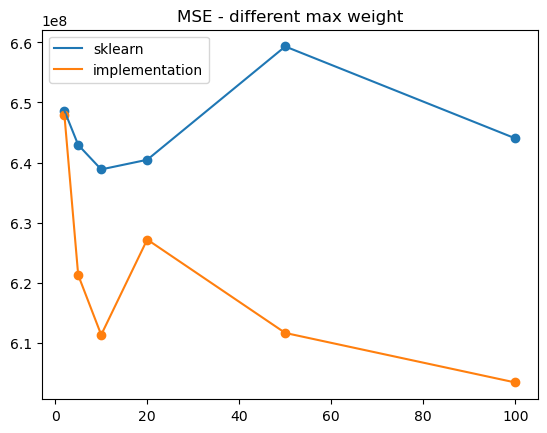

In [29]:
plt.scatter(max_weight, mse_sklearn)
plt.plot(max_weight, mse_sklearn, label="sklearn")
plt.scatter(max_weight, mse_implementation)
plt.plot(max_weight, mse_implementation, label = "implementation")
plt.title("MSE - different max weight")
plt.legend()
plt.show()

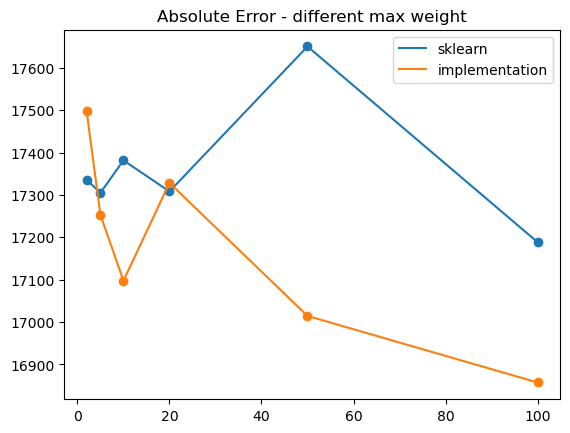

In [30]:
plt.scatter(max_weight, abs_errors_sklearn)
plt.plot(max_weight, abs_errors_sklearn, label="sklearn")
plt.scatter(max_weight, abs_errors_implementation)
plt.plot(max_weight, abs_errors_implementation, label = "implementation")
plt.title("Absolute Error - different max weight")
plt.legend()
plt.show()

In [31]:
scores_sklearn = []
mse_sklearn = []
abs_errors_sklearn = []
times_sklearn = []

scores_implementation = []
mse_implementation = []
abs_errors_implementation = []
times_implementation = []


for max_feat in max_features:
    print(f'START: {max_feat}')
    evaluate_sklearn(max_depth_default, number_of_trees_default, max_feat)
    evaluate_implementation(max_depth_default, number_of_trees_default, max_feat, max_weight_default)



print('SKLEARN')
print('Max features: ', max_features)
print('Mse: ', mse_sklearn)
print('Abs error: ', abs_errors_sklearn)
print('Scores: ', scores_sklearn)
print('Times: ', times_sklearn, '\n')

print('IMPLEMENTATION')
print('Max features: ', max_features)
print('Mse: ', mse_implementation)
print('Abs error: ', abs_errors_implementation)
print('Scores: ', scores_implementation)
print('Times: ', times_implementation)

START: 5
START: 10
START: 15
START: 50
START: 100
START: 200
SKLEARN
Max features:  [5, 10, 15, 50, 100, 200]
Mse:  [801289147.000256, 692342825.9811953, 632661489.948426, 584340992.0326747, 592551892.2046692, 633043457.548482]
Abs error:  [20435.96137923972, 18308.222117694524, 17216.287911239386, 16206.264818534288, 16293.489593924207, 16999.08064667902]
Scores:  [0.8231309882952569, 0.8471787720442896, 0.8603522674808015, 0.8710180786220543, 0.8692056819309674, 0.8602679555539796]
Times:  [1.8046796321868896, 2.180224895477295, 2.409360647201538, 4.266430854797363, 6.844744920730591, 11.613924980163574] 

IMPLEMENTATION
Max features:  [5, 10, 15, 50, 100, 200]
Mse:  [738952062.6232971, 658498875.5139558, 629995884.6090162, 577542111.2755789, 585537023.6928605, 596455087.3948448]
Abs error:  [19741.113808384005, 17955.66618092681, 17162.425145263165, 15983.672759595192, 15977.579880279442, 16244.12085629171]
Scores:  [0.8368906885827041, 0.8546491665875504, 0.8609406480719294, 0.8725

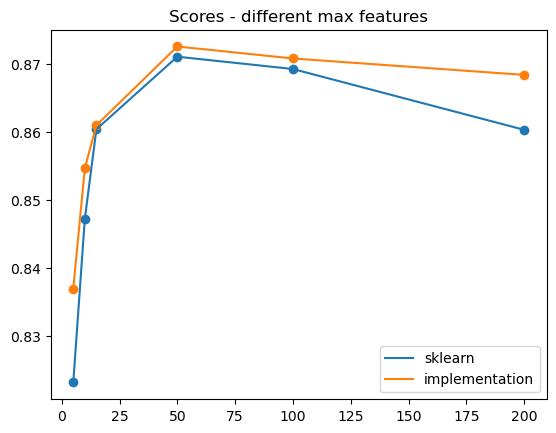

In [32]:
plt.scatter(max_features, scores_sklearn)
plt.plot(max_features, scores_sklearn, label="sklearn")
plt.scatter(max_features, scores_implementation)
plt.plot(max_features, scores_implementation, label = "implementation")
plt.title("Scores - different max features")
plt.legend()
plt.show()

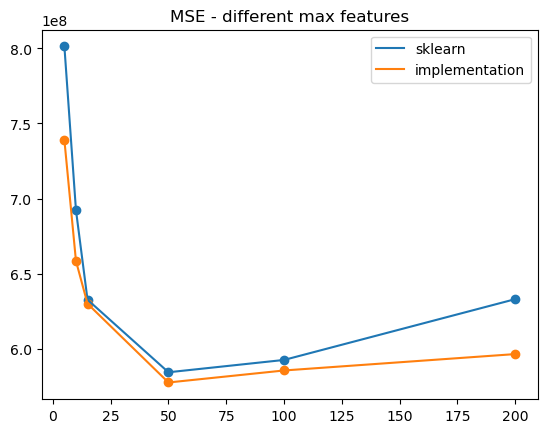

In [33]:
plt.scatter(max_features, mse_sklearn)
plt.plot(max_features, mse_sklearn, label="sklearn")
plt.scatter(max_features, mse_implementation)
plt.plot(max_features, mse_implementation, label = "implementation")
plt.title("MSE - different max features")
plt.legend()
plt.show()

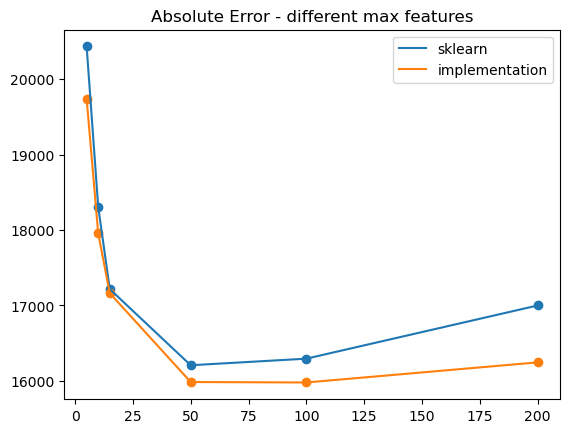

In [34]:
plt.scatter(max_features, abs_errors_sklearn)
plt.plot(max_features, abs_errors_sklearn, label="sklearn")
plt.scatter(max_features, abs_errors_implementation)
plt.plot(max_features, abs_errors_implementation, label = "implementation")
plt.title("Absolute Error - different max features")
plt.legend()
plt.show()

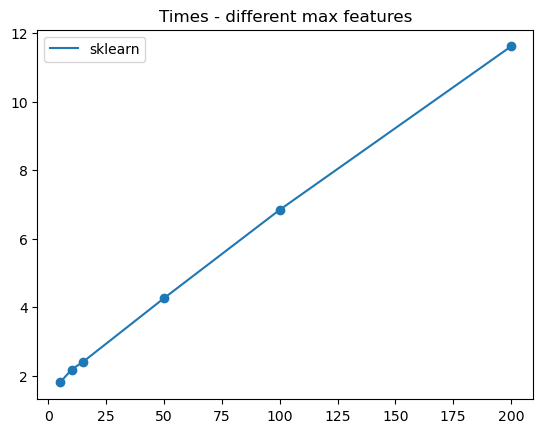

In [35]:
times = [1.8046796321868896, 2.180224895477295, 2.409360647201538, 4.266430854797363, 6.844744920730591, 11.613924980163574]
plt.scatter(max_features, times)
plt.plot(max_features, times, label="sklearn")
plt.title("Times - different max features")
plt.legend()
plt.show()




In [36]:
max_weight = 100
tab_scores = np.zeros(30)
tab_mse = np.zeros(30)
tab_abs_error = np.zeros(30)
for i in range(30):
    print(i)
    trees = []
    number_of_samples = len(x_train)
    errors = [1 for i in range(len(x_train))]
    train_samples = int(0.632*len(x_train))
    for n_tree in range(200):
        samples = np.random.choice(number_of_samples, size=train_samples, replace=True, p=errors/np.sum(errors))
        x_temp = x_train.iloc[samples]
        y_temp = y_train.iloc[samples]
        tree = DecisionTreeRegressor(max_depth=20, max_features=50)
        tree.fit(x_temp, y_temp)
        trees.append(tree)
        values = predict(trees, x_train)
        absolute_error = np.abs(values - y_train)
        errors = np.array([1 for i in range(len(x_train))]) + absolute_error/np.max(absolute_error) * (max_weight - 1)

    y_pred = predict(trees, x_test)
    mse = np.mean((y_test - y_pred)**2)
    abs_error = np.mean(np.abs(y_test - y_pred))
    tab_scores[i] = get_score(trees, x_test, y_test)
    tab_mse[i] = mse
    tab_abs_error[i] = abs_error

print("IMPLEMENTATION:\n")
print(f'Score: {np.mean(tab_scores)}, MSE: {np.mean(tab_mse)}, ABS: {np.mean(tab_abs_error)}\n')



tab_scores_sk = np.zeros(30)
tab_mse_sk = np.zeros(30)
tab_absolute_error_sk = np.zeros(30)
for i in range(30):
    print(i)
    forest = RandomForestRegressor(max_depth=20, n_estimators=100, max_features=50)
    forest.fit(x_train, y_train)
    score = forest.score(x_test, y_test)
    y_pred = forest.predict(x_test)
    mse = np.mean((y_test - y_pred)**2)
    absolute_error = np.mean(np.abs(y_test - y_pred))
    tab_scores_sk[i] = score
    tab_mse_sk[i] = mse
    tab_absolute_error_sk[i] = absolute_error

print("SKLEARN:\n")
print(f'Score: {np.mean(tab_scores_sk)}, MSE: {np.mean(tab_mse_sk)}, ABS: {np.mean(tab_absolute_error_sk)}\n')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
IMPLEMENTATION:

Score: 0.878125529814965, MSE: 552141323.7650611, ABS: 15650.392173494916

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
SKLEARN:

Score: 0.8744236549617206, MSE: 568912334.7797526, ABS: 15903.49773051946

